# 使用OSMnx分析NetworkX街道网络，包括路由

In [1]:
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11dev'

##  计算街道网络的基本属性（拓扑和指标）

In [2]:
# 获取一个网络，计算其基本统计数据并展示平均值
stats = ox.basic_stats(ox.graph_from_place('Haidian District,Beijing,CN')) # 北京市海淀区
stats['circuity_avg']

1.057975437925603

计算基于密度的指标，则还需传入网络的边界区域以确定面积（单位：平方米），否则basic_stats在计算时会跳过这个指标计算

In [3]:
# 通过一个地点获取路网（drive）,其面积单位为：平方米
place = 'Haidian District,Beijing,CN'  # 北京市海淀区
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [4]:
# 计算路网的基本属性和扩展数据以及合并展示
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                  10850
m                                                                                  25316
k_avg                                                                            4.66654
intersection_count                                                                  9335
streets_per_node_avg                                                             2.93631
streets_per_node_counts                {0: 0, 1: 1515, 2: 47, 3: 7038, 4: 2120, 5: 12...
streets_per_node_proportion            {0: 0.0, 1: 0.13963133640552997, 2: 0.00433179...
edge_length_total                                                            4.34851e+06
edge_length_avg                                                                  171.769
street_length_total                                                          2.82093e+06
street_length_avg                                                                178.371
street_segments_count

街道/交叉路口的数量和比例是统计字典中嵌套的字典。要将这些统计信息转换为pandas数据框（以相互比较/分析多个网络），只需首先解压这些嵌套的字典即可：

In [5]:
# unpack dicts into individiual keys:values  将字典分解成各个keys:values 
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements 删除不需要的字典元素
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# load as a pandas dataframe 加载到pandas中
pd.DataFrame(pd.Series(stats)).T

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,...,int_4_count,int_5_count,int_6_count,int_0_prop,int_1_prop,int_2_prop,int_3_prop,int_4_prop,int_5_prop,int_6_prop
0,10850.0,25316.0,4.666544,9335.0,2.936313,4348507.868,171.769153,2820934.572,178.370823,15815.0,...,2120.0,124.0,6.0,0.0,0.139631,0.004332,0.648664,0.195392,0.011429,0.000553


# 检查中介中心性

In [6]:
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(605813123, 0.14410378041449112)

在北京市海淀区，中介中心度最高的节点占通过他的最短路径的  14.4%。让我们在图中突出展示它

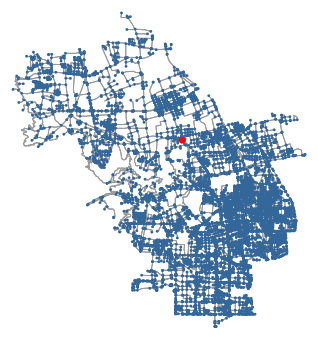

In [7]:
nc = ['r' if node==max_node else '#336699' for node in G_projected.nodes()]
ns = [50 if node==max_node else 8 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2)

所有最短路径中的14.4％经过红色突出显示的节点。让我们看一下图中每个节点的相对中心性：

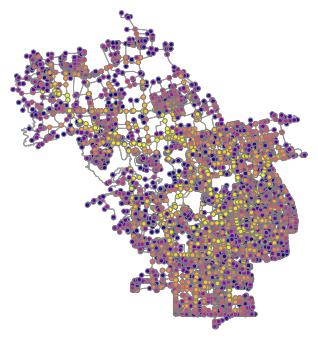

In [8]:
# get a color for each node 给每一个节点赋予一个颜色
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G_projected, node_color=nc, node_edgecolor='gray', node_size=20, node_zorder=2)

在上方，通过中间性中心（从低（深紫色）到高（浅黄色））可视化节点。

# 路由：计算从中心节点到其他某点的网路路径

假设原始节点是最靠近给定位置的节点，为目标节点仅是网络中的最后一个节点。然后使用边权重weight = 'length'，寻找起点和终点之间的最短空间路径，否知，将每一个边的权重设定为1


In [9]:
# define a lat-long point, create network around point, define origin/destination nodes
#定义一个经纬度点，围绕这个点创建网络，定义一个起始点和几个终点
location_point = (39.9525121, 116.3413561)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
origin_node = ox.get_nearest_node(G, location_point)
destination_node = list(G.nodes())[-1]

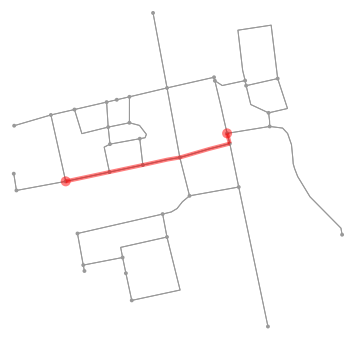

In [10]:
# 寻找起点到终点之间的最短路径，并展示它
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

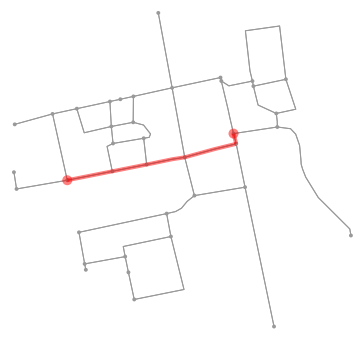

In [11]:
# 投影到UTM,然后再次展示路网和路径
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph_route(G_proj, route)

# 路由：绘制网络路径从一个经纬度坐标到其他

In [12]:
# 定义起始/终点，然后获取类每个点最近的节点
origin_point = (39.9559459, 116.3403184)
destination_point = ( 39.9503124, 116.3341617)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(746856553, 746856372)

In [13]:
# 寻找起始点到各终点之间的最短路径
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[746856553, 746856481, 4177637250, 4177637249, 4177637223, 4177637248, 4177637246, 746856431, 746856372]'

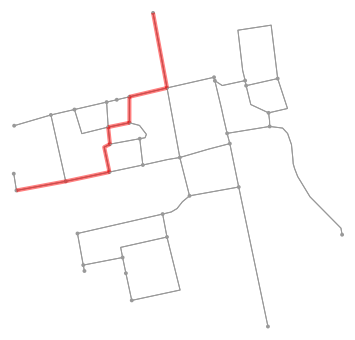

In [14]:
# 绘制起终点之间的路径，使用蓝色绘制起终点
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

# 演示通过单向道路的路径

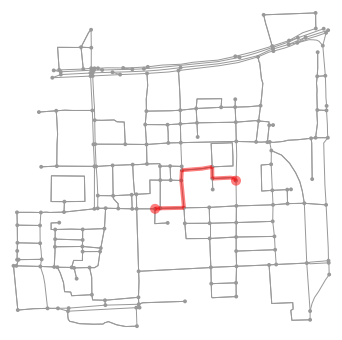

In [15]:
G = ox.graph_from_point((39.8838031, 116.3831972), distance=800, network_type='drive')
origin = (39.8822336, 116.3819754)
destination = ( 39.8832928, 116.3868275)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, save=True, filename='route')

### 另外，当路线中的节点之间有平行边时，OSMnx会选择最短的边进行绘制

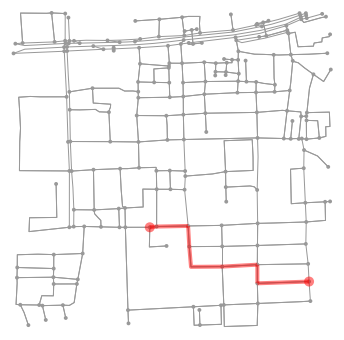

In [16]:
location_point = (39.8838031, 116.3831972)
G = ox.graph_from_point(location_point, distance=600, clean_periphery=False)
origin = (39.8822336, 116.3819754)
destination = ( 39.8800230, 116.3889008)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)